# Two Sigma Data Science Challenge
### Yukun Xu

In [2]:
# Import packages
import pandas as pd
import numpy as np
import scipy

import statsmodels.api as sm
from statsmodels import tsa
from statsmodels.tsa.stattools import adfuller

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.dates import MonthLocator,DateFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn.apionly as sns

from tabulate import tabulate
from cycler import cycler
from tqdm import tqdm

# numpy settings
np.set_printoptions(precision=3)

# pandas settings
pd.set_option('precision', 6)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# matplotlib settings
plt.style.use('ggplot')

mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05 
mpl.rcParams['axes.ymargin'] = 0.05 
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

# figure configuration
fsize=(10,8)  # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

# this allows plots to appear directly in the notebook
%matplotlib inline

## Section 1: Stock Market Data

In [3]:
# Read stock returns data
returns = pd.read_csv('returns_20181228.csv')
returns['Date'] = pd.to_datetime(returns['Date'])
T, N = returns.shape

In [4]:
# Statistics summary of stock returns
returns_summary = returns.describe()

In [5]:
returns_missing = returns_summary.loc['count'][returns_summary.loc['count']<T].sort_values()
print('Number of stocks containing missing returns: ',len(returns_missing))
print('Maximum number of missing returns: ', T-int(min(returns_missing)))

Number of stocks containing missing returns:  92
Maximum number of missing returns:  2


In [6]:
# Remove outliers
returns_rm = returns.copy()
returns_rm.iloc[:,1:N] = returns_rm.iloc[:,1:N][returns_rm.iloc[:,1:N].apply(lambda x: np.abs((x-np.mean(x))/np.std(x))<3, axis=0)]
returns_rm_summary = returns_rm.describe()

In [7]:
returns_rm_missing = returns_rm_summary.loc['count'][returns_rm_summary.loc['count']<T].sort_values()
print('After removing outliers')
print('Number of stocks containing missing returns: ',len(returns_rm_missing))
print('Maximum number of missing returns: ', T-int(min(returns_rm_missing)))

After removing outliers
Number of stocks containing missing returns:  1093
Maximum number of missing returns:  81


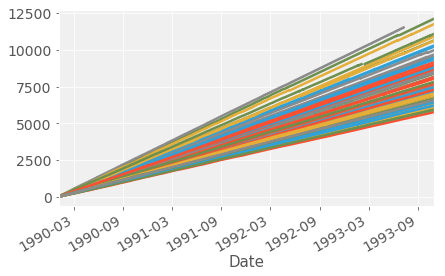

In [8]:
# Detect stocks with abnormal returns 
returns_flaw = returns_rm.copy()
flaw = np.append(True,np.array(returns_rm_summary.loc['min']>0))
returns_flaw = returns_flaw.loc[:,flaw]
returns_flaw_cum = returns_flaw.copy()
returns_flaw_cum.iloc[:,returns_flaw_cum.columns != 'Date'] = returns_flaw_cum.iloc[:,returns_flaw_cum.columns != 'Date'].cumsum()
returns_flaw_cum.plot(x='Date',legend=False)

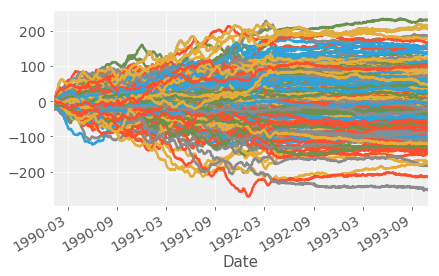

In [9]:
# Keep stocks with normal returns for the further analysis
returns_use = returns_rm.copy()
use = np.append(True,np.array(returns_rm_summary.loc['min']<0))
returns_use = returns_use.loc[:,use]
returns_use_cum = returns_use.copy()
returns_use_cum.iloc[:,returns_use_cum.columns != 'Date'] = returns_use_cum.iloc[:,returns_use_cum.columns != 'Date'].cumsum()
returns_use_cum.plot(x='Date',legend=False)

In [10]:
T, N = returns_use.shape
returns_use_summary = returns_use.describe()
returns_use_missing = returns_use_summary.loc['count'][returns_use_summary.loc['count']<T].sort_values()
print('After removing flaws')
print('Number of stocks: ', N-1)
print('Number of stocks containing missing returns: ',len(returns_use_missing))
print('Maximum number of missing returns: ', T-int(min(returns_use_missing)))

After removing flaws
Number of stocks:  1043
Number of stocks containing missing returns:  1003
Maximum number of missing returns:  41


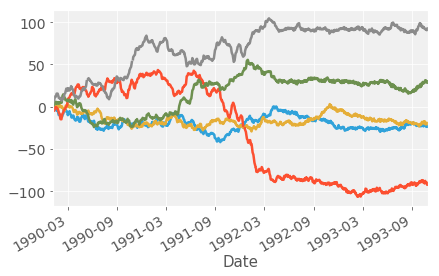

In [11]:
# Visualize the first five stocks returns
returns_use_cum.iloc[:,0:6].plot(x='Date',legend=False)

### Momentum and Mean Reversion

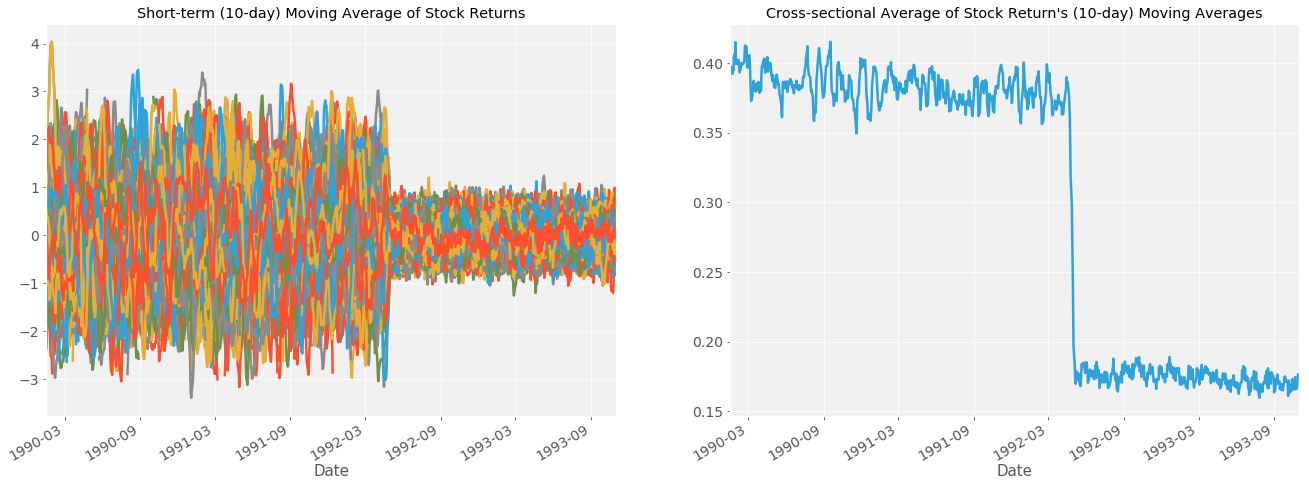

In [12]:
# Look at the short-term moving average of stock returns to see whether there exists significant change
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
returns_ma = returns_use.copy()
returns_ma.iloc[:,1:N] = returns_ma.iloc[:,1:N].rolling(10).mean()
returns_ma.iloc[9:,:].plot(x='Date',legend=False,ax=axes[0],title='Short-term (10-day) Moving Average of Stock Returns')

xs = returns_ma.iloc[9:,0:2]
xs.iloc[:,1:2] = returns_ma.iloc[9:,1:N].apply(lambda x: np.mean(np.abs(x)), axis=1)
xs.columns = ['Date','Average']
xs.plot(x='Date',legend=False,ax=axes[1],title="Cross-sectional Average of Stock Return's (10-day) Moving Averages")

Based on the above plots, we expect the market shifted from momentum dominant to mean-reversion dominant between 1992-03 and 1992-09.

To determine the specific month when the regime shifting happened and the average momentum/mean reversion in their coresponding time period, we creat two synthetic portfolio with momentum and mean reversion strategies respectively. The momentum strategy is simply buying high and selling higher; while the mean reversion startegy is buying low and selling high. To avoid noisy signals, we look at the past 10-day moving average of each stock. 

The portfolio with momentum strategy starts trading on the 10th day of this observed time period, buying stocks with past 10-day moving averages positive and selling stocks with past 10-day moving averages negative. The portfolio with mean reversion strategy also starts trading on the 10th day, but buying stocks with past 10-day moving averages negative and selling stocks with past 10-day moving averages positive. 

In [13]:
# Functions that implement momentum and mean reversion strategies
def momentum(x):
    y = x.copy()
    y[x>0]=1 # buy stocks
    y[x<0]=-1 # sell stocks
    return y

def mean_reversion(x):
    y = x.copy()
    y[x>0]=-1 # sell stocks
    y[x<0]=1 # buy stocks
    return y

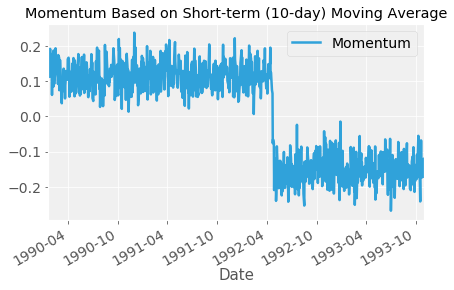

In [14]:
actions_momentum = returns_ma.iloc[9:,1:N].apply(lambda x: momentum(x), axis=1).iloc[:-1,:]
actions_momentum = actions_momentum.reset_index(drop=True)

returns_momentum = returns_use.iloc[10:,:]
returns_momentum = returns_momentum.reset_index(drop=True)
returns_momentum.iloc[:,1:N] = returns_momentum.iloc[:,1:N].mul(actions_momentum)

returns_momentum['Momentum'] = returns_momentum.iloc[:,1:N].apply(lambda x: np.mean(x), axis=1)
returns_momentum.loc[:,['Date','Momentum']].plot(x='Date',title='Momentum Based on Short-term (10-day) Moving Average')

In [15]:
returns_momentum[returns_momentum['Momentum']<0].sort_values(by='Date').head()

,Date,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,...,stock_1132,stock_1133,stock_1134,stock_1135,stock_1136,stock_1137,stock_1138,stock_1139,stock_1140,Momentum
590,1992-04-23,-0.7452,-1.6271,-0.5051,-1.5351,1.4260,0.0000,0.8524,1.4582,1.0254,...,-1.0431,0.7691,1.1795,-0.4155,-0.4750,0.9768,0.5553,0.0343,-0.0338,-0.0764
591,1992-04-24,-0.6053,0.0502,-1.0470,-1.8100,1.1461,0.0000,-0.3585,0.2062,-1.4948,...,1.1238,0.2616,0.2698,-0.8446,-2.1298,-1.8099,0.0770,-1.0032,0.8078,-0.0656
592,1992-04-27,0.3377,-0.8267,-0.1048,-0.0310,-1.6780,0.0000,0.4806,0.4415,1.4832,...,0.7125,-2.2875,-1.5179,-0.0966,0.7959,0.0726,1.3697,-0.2285,0.1827,-0.0766
593,1992-04-28,0.2161,-0.9720,0.8381,-0.1899,-0.1582,0.0000,0.5938,0.0410,-1.5005,...,-0.5335,-0.6242,0.7383,0.0892,-1.7643,-1.1383,-3.9724,-0.6699,-0.5435,-0.2095
594,1992-04-29,-0.3769,-0.8763,-0.3260,-0.5580,0.2073,0.0000,0.1935,-0.7086,0.1094,...,0.8108,-0.3237,0.5631,-1.1723,-0.4456,-1.1991,1.8915,0.7183,-0.2785,-0.1221


In [16]:
average_momentum = returns_momentum[returns_momentum['Date'].map(lambda x: 100*x.year + x.month)<199204].Momentum.mean()
print('Average momentum before shifting: %.7f' % average_momentum)

Average momentum before shifting: 0.1161595


Based on the performance of our momentum portfolio, it generated positive returns by capturing the momentum signals before the end of April in 1992. When the market shifted from momentum dominant to mean reversion dominant in April, its returns kept being negative indicating that the market was mean reverting. 

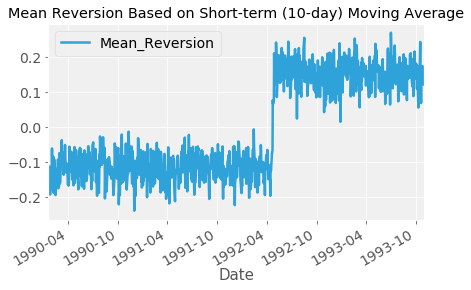

In [17]:
actions_mean_reversion = returns_ma.iloc[9:,1:N].apply(lambda x: mean_reversion(x), axis=1).iloc[:-1,:]
actions_mean_reversion = actions_mean_reversion.reset_index(drop=True)

returns_mean_reversion = returns_use.iloc[10:,:]
returns_mean_reversion = returns_mean_reversion.reset_index(drop=True)

returns_mean_reversion.iloc[:,1:N] = returns_mean_reversion.iloc[:,1:N].mul(actions_mean_reversion)
returns_mean_reversion['Mean_Reversion'] = returns_mean_reversion.iloc[:,1:N].apply(lambda x: np.mean(x), axis=1)
returns_mean_reversion.loc[:,['Date','Mean_Reversion']].plot(x='Date',title='Mean Reversion Based on Short-term (10-day) Moving Average')

In [18]:
returns_mean_reversion[returns_mean_reversion['Mean_Reversion']>0].sort_values(by='Date').head()

,Date,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,...,stock_1132,stock_1133,stock_1134,stock_1135,stock_1136,stock_1137,stock_1138,stock_1139,stock_1140,Mean_Reversion
590,1992-04-23,0.7452,1.6271,0.5051,1.5351,-1.4260,-0.0000,-0.8524,-1.4582,-1.0254,...,1.0431,-0.7691,-1.1795,0.4155,0.4750,-0.9768,-0.5553,-0.0343,0.0338,0.0764
591,1992-04-24,0.6053,-0.0502,1.0470,1.8100,-1.1461,-0.0000,0.3585,-0.2062,1.4948,...,-1.1238,-0.2616,-0.2698,0.8446,2.1298,1.8099,-0.0770,1.0032,-0.8078,0.0656
592,1992-04-27,-0.3377,0.8267,0.1048,0.0310,1.6780,-0.0000,-0.4806,-0.4415,-1.4832,...,-0.7125,2.2875,1.5179,0.0966,-0.7959,-0.0726,-1.3697,0.2285,-0.1827,0.0766
593,1992-04-28,-0.2161,0.9720,-0.8381,0.1899,0.1582,-0.0000,-0.5938,-0.0410,1.5005,...,0.5335,0.6242,-0.7383,-0.0892,1.7643,1.1383,3.9724,0.6699,0.5435,0.2095
594,1992-04-29,0.3769,0.8763,0.3260,0.5580,-0.2073,-0.0000,-0.1935,0.7086,-0.1094,...,-0.8108,0.3237,-0.5631,1.1723,0.4456,1.1991,-1.8915,-0.7183,0.2785,0.1221


In [19]:
average_mean_reversion = returns_mean_reversion[returns_mean_reversion['Date'].map(lambda x: 100*x.year + x.month)>199204].Mean_Reversion.mean()
print('Average mean reversion after shifting: %.7f' % average_mean_reversion)

Average mean reversion after shifting: 0.1513051


The performance of our mean reversion portfolio exhibited the opposite performance to our momentum portfolio. Indeed, it generated negative returns by trading against the market's trend before the end of April in 1992. When the market shifted from momentum dominant to mean reversion dominant in April, its returns became positve by capturing the mean reversion signals. 

## Section 2: Oklahoma State Spending

In [20]:
# Read transaction data
transactions = pd.read_csv('res_purchase_2014.csv',low_memory=False)
transactions['Transaction Date'] = pd.to_datetime(transactions['Transaction Date'])
transactions['Posted Date'] = pd.to_datetime(transactions['Posted Date'])

In [21]:
# Clean the transaction amount by removing characters and considering negative amount
transactions['Amount'] = transactions['Amount'].replace(r"[a-zA-Z]",'',regex=True).replace('[\$,)]','',regex=True).replace('[(]','-',regex=True).astype(float)

In [22]:
transactions.head(16)

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.0000,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.9600,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.8200,SEARS.COM 9300,2013-07-29,2013-07-31,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.3900,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.9600,STAPLES DIRECT,2013-07-30,2013-07-31,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."
5,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,GENERAL PURCHASE,394.2800,KYOCERA DOCUMENT SOLUTION,2013-07-29,2013-07-31,"OFFICE, PHOTOGRAPHIC, PHOTOCOPY, AND MICROFILM..."
6,201307,1000,OKLAHOMA STATE UNIVERSITY,Mays,B,GENERAL PURCHASE,19.8700,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS"
7,201307,1000,OKLAHOMA STATE UNIVERSITY,Mays,B,GENERAL PURCHASE,10.1000,DAYLIGHT DONUTS,2013-07-29,2013-07-31,FAST FOOD RESTAURANTS
8,201307,1000,OKLAHOMA STATE UNIVERSITY,McCarthy,D,GENERAL PURCHASE,142.6000,UFIRST LAUNDRY SVCS,2013-07-30,2013-07-31,"MENS, WOMENS AND CHILDRENS UNIFORMS AND COMMER..."
9,201307,1000,OKLAHOMA STATE UNIVERSITY,McClurg,L,AT&T SERVICE PAYMENT ITM,-29.9900,AT&T DATA,2013-07-30,2013-07-31,TELECOMMUNICATION SERVICES


In [23]:
print('Total amount of spending captured in this dataset: ', transactions['Amount'].sum())

Total amount of spending captured in this dataset:  188040606.23


In [24]:
# Packages used to clean text data
from nltk.tokenize import word_tokenize
import string

In [25]:
# Clean vendor information
vendors = transactions['Vendor']

# split into words
tokens = [word_tokenize(v) for v in vendors]
# convert to upper case
tokens = [[w.upper() for w in v] for v in tokens]
# remove punctuation from each word
table = str.maketrans('', '', string.punctuation)
stripped = [[w.translate(table) for w in v] for v in tokens]
# remove remaining tokens that are not alphabetic
words = [[w for w in v if w.isalpha()] for v in stripped]
# recombine words into vendors
transactions['Vendor'] = [' '.join(v) for v in words]

In [26]:
transactions.head(16)

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.0000,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.9600,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.8200,SEARSCOM,2013-07-29,2013-07-31,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.3900,WALMART,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.9600,STAPLES DIRECT,2013-07-30,2013-07-31,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."
5,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,GENERAL PURCHASE,394.2800,KYOCERA DOCUMENT SOLUTION,2013-07-29,2013-07-31,"OFFICE, PHOTOGRAPHIC, PHOTOCOPY, AND MICROFILM..."
6,201307,1000,OKLAHOMA STATE UNIVERSITY,Mays,B,GENERAL PURCHASE,19.8700,WALMART,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS"
7,201307,1000,OKLAHOMA STATE UNIVERSITY,Mays,B,GENERAL PURCHASE,10.1000,DAYLIGHT DONUTS,2013-07-29,2013-07-31,FAST FOOD RESTAURANTS
8,201307,1000,OKLAHOMA STATE UNIVERSITY,McCarthy,D,GENERAL PURCHASE,142.6000,UFIRST LAUNDRY SVCS,2013-07-30,2013-07-31,"MENS, WOMENS AND CHILDRENS UNIFORMS AND COMMER..."
9,201307,1000,OKLAHOMA STATE UNIVERSITY,McClurg,L,AT&T SERVICE PAYMENT ITM,-29.9900,AT T DATA,2013-07-30,2013-07-31,TELECOMMUNICATION SERVICES


### Amount spent at WW GRAINGER
This amount contains the claims made at WW GRAINGER.

In [27]:
WG = transactions[transactions['Vendor'].str.contains('WW GRAINGER')]
WG.head()

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
50,201307,1000,OKLAHOMA STATE UNIVERSITY,Davis,G,Disposable GlovesNitrile EA|Ear Plugs32dBW/o C...,714.9400,WW GRAINGER,2013-07-24,2013-07-26,INDUSTRIAL SUPPLIES NOT ELSEWHERE CLASSIFIED
171,201307,1000,OKLAHOMA STATE UNIVERSITY,Akem,A,Motor1/3 HP1725 RPM115 EA,310.8600,WW GRAINGER,2013-07-29,2013-07-30,INDUSTRIAL SUPPLIES NOT ELSEWHERE CLASSIFIED
232,201307,1000,OKLAHOMA STATE UNIVERSITY,Hines,G,-SCREW WITH SPRING EA|EP1CS1521 CABLE HOLDR AS...,569.7500,WW GRAINGER,2013-07-26,2013-07-29,INDUSTRIAL SUPPLIES NOT ELSEWHERE CLASSIFIED
256,201307,1000,OKLAHOMA STATE UNIVERSITY,Heusel,J,PUMP WITH SIDE MOUNTED FL EA,1691.6800,WW GRAINGER,2013-07-26,2013-07-29,INDUSTRIAL SUPPLIES NOT ELSEWHERE CLASSIFIED
269,201307,1000,OKLAHOMA STATE UNIVERSITY,Seshadri,A,AngleAl60611/4 In T1 EA|Radial Ball Bearing EA...,40.6600,WW GRAINGER,2013-07-29,2013-07-31,INDUSTRIAL SUPPLIES NOT ELSEWHERE CLASSIFIED


In [28]:
print('Total amount spent at WW GRAINGER: ', WG['Amount'].sum())

Total amount spent at WW GRAINGER:  5089340.56


### Amount spent at WM SUPERCENTER
This amount contains the claims made at WM SUPERCENTER.

In [29]:
WS = transactions[transactions['Vendor'].str.contains('WM SUPERCENTER')]
WS.head()

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
265446,201403,1000,OKLAHOMA STATE UNIVERSITY,Maples,D,GENERAL PURCHASE,39.9400,WM SUPERCENTER,2014-03-20,2014-03-21,"GROCERY STORES,AND SUPERMARKETS"
265463,201403,1000,OKLAHOMA STATE UNIVERSITY,Miller,B,GENERAL PURCHASE,32.0300,WM SUPERCENTER,2014-03-20,2014-03-21,"GROCERY STORES,AND SUPERMARKETS"
265543,201403,1000,OKLAHOMA STATE UNIVERSITY,Hines,J,GENERAL PURCHASE,95.2600,WM SUPERCENTER,2014-03-20,2014-03-21,"GROCERY STORES,AND SUPERMARKETS"
265559,201403,1000,OKLAHOMA STATE UNIVERSITY,Huber,J,GENERAL PURCHASE,103.2000,WM SUPERCENTER,2014-03-20,2014-03-21,"GROCERY STORES,AND SUPERMARKETS"
265584,201403,1000,OKLAHOMA STATE UNIVERSITY,GILROY,L,GENERAL PURCHASE,179.9100,WM SUPERCENTER,2014-03-20,2014-03-21,"GROCERY STORES,AND SUPERMARKETS"


In [30]:
print('Total amount spent at WM SUPERCENTER: ', WS['Amount'].sum())

Total amount spent at WM SUPERCENTER:  157457.46


### Monthly transactions

In [31]:
# Identify the data issue of Year-Month
transactions['Year-Month'].unique()

array([201307, 201402, 201401, 201406, 201309, 201403, 201308, 201310,
       201311, 201312, 201405, 201404, 201900,   -999])

In [33]:
print('The posted date of a transaction starts from %s and ends on %s' % (transactions['Posted Date'].min().strftime("%Y-%m-%d"), 
                                                                        transactions['Posted Date'].max().strftime("%Y-%m-%d")))
print("Therefore, we know that 'Year-Month' should be consistant with the posted date of transaction.")

The posted date of a transaction starts from 2013-07-01 and ends on 2014-06-30
Therefore, we know that 'Year-Month' should be consistant with the posted date of transaction.


In [34]:
transactions.loc[transactions['Year-Month'].isin([201900, -999]), 'Year-Month'] = transactions.loc[transactions['Year-Month'].isin([201900, -999]), 'Posted Date'].map(lambda x: int(100*x.year + x.month))
transactions['Year-Month'].unique()

array([201307, 201402, 201401, 201406, 201309, 201403, 201308, 201310,
       201311, 201312, 201405, 201404])

In [35]:
# Test whether 'Year-Month' is consistent with 'Posted Date'
transactions[transactions['Year-Month']!=transactions['Posted Date'].map(lambda x: int(100*x.year + x.month))]

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)


In [36]:
transactions_monthly = pd.concat([transactions[transactions['Amount']>0].groupby('Year-Month')['Amount'].count(),
                                  transactions[transactions['Amount']<0].groupby('Year-Month')['Amount'].count(),
                                  transactions.groupby('Year-Month')['Amount'].sum()],axis=1)
transactions_monthly.columns = ['Positive Trans', 'Negative Trans', 'Amount']
transactions_monthly = transactions_monthly.reset_index()
transactions_monthly

,Year-Month,Positive Trans,Negative Trans,Amount
0,201307,36437,1198,15775795.5200
1,201308,38028,1286,17889498.6000
2,201309,37544,1218,17511465.3200
3,201310,38842,1424,17547182.6700
4,201311,33182,1093,13040662.2000
5,201312,26095,874,11758180.7800
6,201401,36156,1074,14794024.0700
7,201402,34639,1191,13940362.8600
8,201403,36933,1255,17599123.3700
9,201404,37930,1319,16689778.8600


In [37]:
print('Standard deviation of the total monthly spending in the dataset: ', np.std(transactions_monthly['Amount']))

Standard deviation of the total monthly spending in the dataset:  1913901.02542


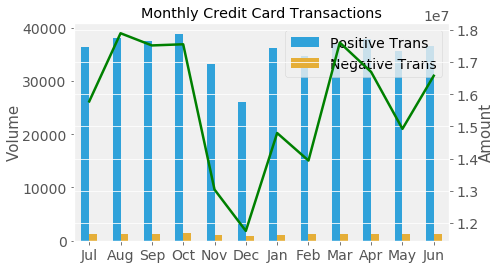

In [38]:
# Visualize the monthly transactions by volume and amount
width=0.5
transactions_monthly[['Positive Trans','Negative Trans']].plot(kind='bar',title='Monthly Credit Card Transactions').set_ylabel('Volume')
transactions_monthly['Amount'].plot(secondary_y=True,color='green').set_ylabel('Amount')
ax = plt.gca()
plt.xlim([-width, len(transactions_monthly['Positive Trans'])-width])
ax.set_xticklabels(['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])

### Observations based on this dataset 

In [39]:
# Clean Merchant Category
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

category = transactions['Merchant Category Code (MCC)']

# split into words
tokens = [word_tokenize(c) for c in category]
# convert to upper case
tokens = [[w.upper() for w in c] for c in tokens]
# remove punctuation from each word
table = str.maketrans('', '', string.punctuation)
stripped = [[w.translate(table) for w in c] for c in tokens]
# remove remaining tokens that are not alphabetic
words = [[w for w in c if w.isalpha()] for c in stripped]
# filter out stop words
words = [[w for w in c if not w in stop_words] for c in words]
transactions['Merchant Category Code (MCC)'] = [' '.join(w) for w in words]

In [40]:
# Clean Agency Name
agency = transactions['Agency Name']

# split into words
tokens = [word_tokenize(c) for c in agency]
# convert to upper case
tokens = [[w.upper() for w in c] for c in tokens]
# remove punctuation from each word
table = str.maketrans('', '', string.punctuation)
stripped = [[w.translate(table) for w in c] for c in tokens]
# remove remaining tokens that are not alphabetic
words = [[w for w in c if w.isalpha()] for c in stripped]
# filter out stop words
words = [[w for w in c if not w in stop_words] for c in words]
transactions['Agency Name'] = [' '.join(w) for w in words]

In [41]:
transactions.head(16)

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.0000,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.9600,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.8200,SEARSCOM,2013-07-29,2013-07-31,DIRCT MARKETINGDIRCT MARKETERS NOT ELSEWHERE C...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.3900,WALMART,2013-07-30,2013-07-31,GROCERY STORES AND SUPERMARKETS
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.9600,STAPLES DIRECT,2013-07-30,2013-07-31,STATIONERY OFFICE SUPPLIES PRINTING AND WRITIN...
5,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,GENERAL PURCHASE,394.2800,KYOCERA DOCUMENT SOLUTION,2013-07-29,2013-07-31,OFFICE PHOTOGRAPHIC PHOTOCOPY AND MICROFILM EQ...
6,201307,1000,OKLAHOMA STATE UNIVERSITY,Mays,B,GENERAL PURCHASE,19.8700,WALMART,2013-07-30,2013-07-31,GROCERY STORES AND SUPERMARKETS
7,201307,1000,OKLAHOMA STATE UNIVERSITY,Mays,B,GENERAL PURCHASE,10.1000,DAYLIGHT DONUTS,2013-07-29,2013-07-31,FAST FOOD RESTAURANTS
8,201307,1000,OKLAHOMA STATE UNIVERSITY,McCarthy,D,GENERAL PURCHASE,142.6000,UFIRST LAUNDRY SVCS,2013-07-30,2013-07-31,MENS WOMENS AND CHILDRENS UNIFORMS AND COMMERC...
9,201307,1000,OKLAHOMA STATE UNIVERSITY,McClurg,L,AT&T SERVICE PAYMENT ITM,-29.9900,AT T DATA,2013-07-30,2013-07-31,TELECOMMUNICATION SERVICES


In [44]:
# Function for wordcloud visualization, word's size indicates its freqency of occurrence 
from wordcloud import WordCloud

mpl.rcParams['font.size']=12                 
mpl.rcParams['savefig.dpi']=100              
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=500,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

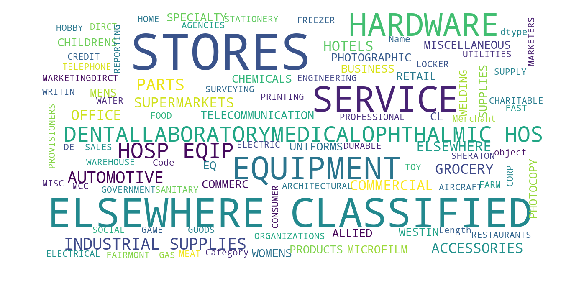

In [45]:
# Frequency of Merchant Category
show_wordcloud(transactions['Merchant Category Code (MCC)'])

In [53]:
# Merchant categories with highest total transaction amount
transactions_category = transactions.groupby('Merchant Category Code (MCC)')['Amount'].sum()
transactions_category = transactions_category.reset_index()
transactions_category.sort_values(by='Amount',ascending=False).head(10)

,Merchant Category Code (MCC),Amount
124,DENTALLABORATORYMEDICALOPHTHALMIC HOSP EQIP AN...,11004961.3400
219,INDUSTRIAL SUPPLIES NOT ELSEWHERE CLASSIFIED,10846843.3000
105,COMPUTERS COMPUTER PERIPHERAL EQUIPMENT SOFTWARE,10091600.7600
96,COMMERCIAL EQUIPMENT NOT ELSEWHERE CLASSIFIED,8139120.6900
268,MISCELLANEOUS AND SPECIALTY RETAIL STORES,5563077.1100
23,AMERICAN AIRLINES,5296951.0400
62,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,5218792.4000
368,STATIONERY OFFICE SUPPLIES PRINTING AND WRITIN...,5094192.2500
128,DIRCT MARKETINGDIRCT MARKETERS NOT ELSEWHERE C...,4731575.1500
297,OTHER FEES,4076934.7900


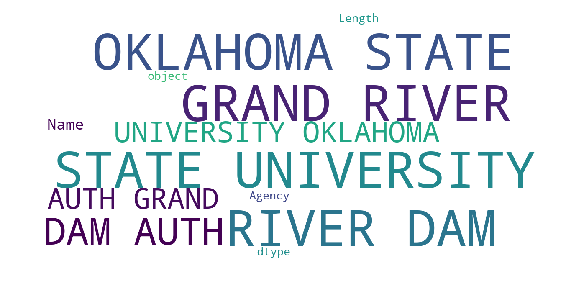

In [47]:
# Frequency of Agencies
show_wordcloud(transactions['Agency Name'])

In [52]:
# Agencies who made highest total transaction amount
transactions_agency = transactions.groupby('Agency Name')['Amount'].sum()
transactions_agency = transactions_agency.reset_index()
transactions_agency.sort_values(by='Amount',ascending=False).head(10)

,Agency Name,Amount
82,OKLAHOMA STATE UNIVERSITY,33778779.9600
116,UNIVERSITY OF OKLAHOMA,24886382.8900
114,UNIV OF OKLA HEALTH SCIENCES CENTER,24527325.1300
44,GRAND RIVER DAM AUTH,22213829.2600
33,DEPARTMENT OF TRANSPORTATION,14399262.0300
22,DEPARTMENT OF CORRECTIONS,13988871.9000
32,DEPARTMENT OF TOURISM AND RECREATION,5971885.2900
34,DEPARTMENT OF VETERANS AFFAIRS,4242096.6500
59,OFFICE OF MANAGEMENT AND ENTERPRISE SERV,3874001.1200
81,OKLAHOMA MILITARY DEPARTMENT,3697283.2200


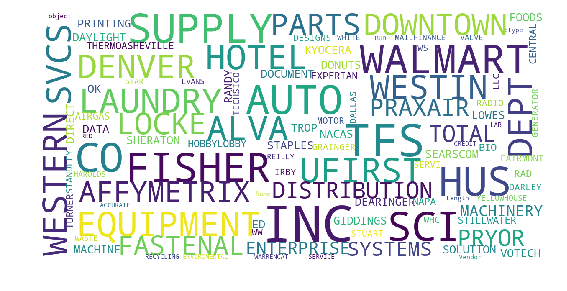

In [49]:
# Frequency of Vendors
show_wordcloud(transactions['Vendor'])

In [51]:
# Vendors with highest total transaction amount
transactions_vendor = transactions.groupby('Vendor')['Amount'].sum()
transactions_vendor = transactions_vendor.reset_index()
transactions_vendor.sort_values(by='Amount',ascending=False).head(10)

,Vendor,Amount
1370,AMERICAN AI,5296951.0400
35701,WW GRAINGER,5089417.4800
24715,PAYMENT ADJUSTMENT,4061760.5300
7888,DMI DELL,3457511.4700
7893,DMI DELL HIGHER EDUC,2641101.0600
31114,STAPLES,2568555.3700
8947,EMC CORPORATION,2154664.9600
30103,SOUTH CENTRAL INDUSTRIES,2028479.8900
26432,PELCO STRUCTURAL LLC,1944523.0000
30184,SOUTHWES,1919467.3900


In [54]:
# Function that visualizes monthly transactions made through a vendor
def monthly_transactions(vendor):
    df = pd.concat([transactions[transactions['Vendor']==vendor].groupby('Year-Month')['Amount'].count(),
                    transactions[transactions['Vendor']==vendor].groupby('Year-Month')['Amount'].sum()],axis=1)
    df.columns = ['Volume', 'Amount']
    df = df.reset_index()
    width=0.5
    df['Volume'].plot(kind='bar').set_ylabel('Volume')
    df['Amount'].plot(secondary_y=True,color='green').set_ylabel('Amount')
    ax = plt.gca()
    plt.xlim([-width, len(df['Volume'])-width])
    ax.set_xticklabels(['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])
    ax.set_title('Monthly Credit Card Transactions for %s' % vendor)

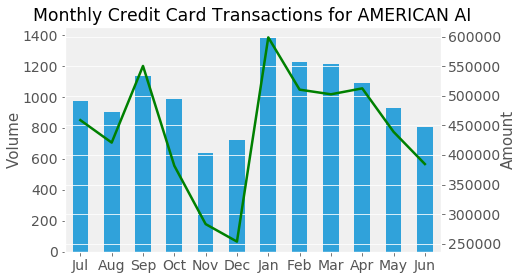

In [55]:
# Monthly transactions made through American Airline
monthly_transactions('AMERICAN AI')

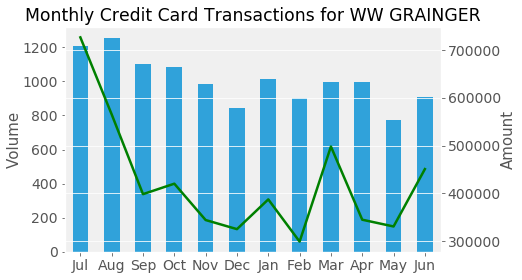

In [56]:
# Monthly transactions made through WW GRAINGER
monthly_transactions('WW GRAINGER')

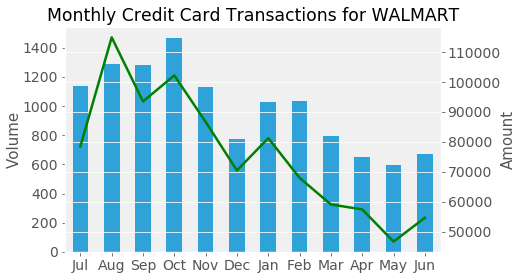

In [57]:
# Monthly transactions made through Walmart
monthly_transactions('WALMART')